CRAWL DATA

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

In [28]:
# URL của trang chính
base_url = "https://elise.vn/"
res = requests.get(base_url)
soup = BeautifulSoup(res.text, 'html.parser')

# Danh sách để lưu trữ dữ liệu
data = []

In [37]:
# Hàm để lấy thông tin sản phẩm
def get_product_info(product_url, category_name, category_url,type_name):
    item = {}
    try:
        product_res = requests.get(product_url, timeout=10)
        product_soup = BeautifulSoup(product_res.text, 'html.parser')
        item["category"] = category_name
        item["sub category"] = type_name
        item["product url"] = product_url

        title = product_soup.find("h1", class_="product-name").get_text().strip()
        item["title"] = title

        sku = product_soup.find("span", itemprop="sku").get_text().strip()
        item["sku"] = sku

        price_str = product_soup.find("span", class_="price").get_text().replace("\xa0", " ")
        item["price string"] = price_str

        # Lấy thông tin hình ảnh
        images_link = []
        img_list = product_soup.find("div", class_="xxx product media").find_all("img", class_="img-responsive")
        for img in img_list:
            images_link.append(img.get("data-src") or img.get("src"))

        item['images'] = images_link
    except Exception as e:
        print(f"Error fetching {product_url}: {e}")
    return item

# Lấy URL các nhóm sản phẩm
categories = soup.findAll("li", class_="category-menu level0 dropdown")
# Sử dụng ThreadPoolExecutor để truy xuất sản phẩm đồng thời
with ThreadPoolExecutor(max_workers=10) as executor: 
    futures = []
    for category in categories[:-1]:  
        category_name = category.find("span").get_text()
        types = category.find("li").find_all("a")
        print(types)
        for type_ in types:
            type_name = type_.get_text().strip()
            
            category_url = type_["href"]

            # Truy cập trang nhóm sản phẩm để lấy URL các sản phẩm
            category_res = requests.get(category_url)
            category_soup = BeautifulSoup(category_res.text, 'html.parser')

            product_wrapper = category_soup.find("div", id="product-wrapper")
            if product_wrapper:
                product_items = product_wrapper.find_all("li")

                for product in product_items:
                    product_url = product.find("a")["href"]
                    futures.append(executor.submit(get_product_info, product_url, category_name, category_url,type_name))

    # Lấy kết quả từ các futures
    for future in as_completed(futures):
        result = future.result()
        if result:
            data.append(result)

In [38]:
# Tạo DataFrame từ danh sách
df = pd.DataFrame(data)

# Xuất kết quả
df

,category,sub category,product url,title,sku,price string,images
0,PHỤ KIỆN,Giày / Dép,https://elise.vn/dep-got-tru-nau-in-logo-fs240...,DÉP GÓT TRỤ NÂU IN LOGO,FS2401137FSPUBR,1.598.000 VND,[https://elise.vn/media/catalog/product/cache/...
1,PHỤ KIỆN,Giày / Dép,https://elise.vn/fs2305003fspubl.html,GIÀY MULES CAO GÓT DA TRƠN MŨI VUÔNG,FS2305003FSPUBL,1.798.000 VND,[https://elise.vn/media/catalog/product/cache/...
2,PHỤ KIỆN,Giày / Dép,https://elise.vn/giay-cao-got-trang-dinh-no-fs...,GIÀY CAO GÓT TRẮNG ĐÍNH NƠ,FS2401135FSPUWH,1.898.000 VND,[https://elise.vn/media/catalog/product/cache/...
3,PHỤ KIỆN,Giày / Dép,https://elise.vn/fs2304004fspube.html,GIÀY SLINGBACK DA XOẮN MŨI NHỌN,FS2304004FSPUBE,1.798.000 VND,[https://elise.vn/media/catalog/product/cache/...
4,PHỤ KIỆN,Giày / Dép,https://elise.vn/fs2304005fswobk.html,GIÀY CAO GÓT DA LỘN PHỐI NƠ,FS2304005FSWOBK,1.998.000 VND,[https://elise.vn/media/catalog/product/cache/...
...,...,...,...,...,...,...,...
283,PHỤ KIỆN,Phụ Kiện,https://elise.vn/fs2212143abpupb.html,THẮT LƯNG DA ĐEN CHỮ ELISE BẠC,FS2212143ABPUPB,598.000 VND,[https://elise.vn/media/catalog/product/cache/...
284,PHỤ KIỆN,Phụ Kiện,https://elise.vn/fs2212144abpupk.html,THẮT LƯNG DA ĐEN THANH CHỮ ELISE BẠC,FS2212144ABPUPK,598.000 VND,[https://elise.vn/media/catalog/product/cache/...
285,PHỤ KIỆN,Phụ Kiện,https://elise.vn/fs2212145abpubk.html,THẮT LƯNG DA ĐEN XÍCH LOGO VÀNG,FS2212145ABPUBK,598.000 VND,[https://elise.vn/media/catalog/product/cache/...
286,PHỤ KIỆN,Phụ Kiện,https://elise.vn/fw2208086abpuwh.html,THẮT LƯNG TRẮNG LOGO ELISE BẠC,FW2208086ABPUWH,498.000 VND,[https://elise.vn/media/catalog/product/cache/...


In [8]:
# Convert list to DataFrame
df = pd.DataFrame(data)

# Write DataFrame to CSV file
df.to_excel("C:/Users/Documents/Nhiem vu bo sung/Nhiem vu bo sung.xlsx" , index=False)

EDA

In [10]:
df = pd.read_excel("C:/Users/Documents/Nhiem vu bo sung/Nhiem vu bo sung.xlsx")

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Kiểm tra cấu trúc dữ liệu
print("Thông tin dữ liệu:")
print(df.info())

# Kiểm tra giá trị thiếu
print("\nKiểm tra giá trị thiếu:")
print(df.isnull().sum())

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   category      361 non-null    object
 1   sub category  361 non-null    object
 2   product url   361 non-null    object
 3   title         361 non-null    object
 4   sku           361 non-null    object
 5   price string  361 non-null    object
 6   images        361 non-null    object
dtypes: object(7)
memory usage: 19.9+ KB
None

Kiểm tra giá trị thiếu:
category        0
sub category    0
product url     0
title           0
sku             0
price string    0
images          0
dtype: int64


In [12]:
# Thiết lập bảng màu cho Seaborn
custom_palette = ["#015f69", "#d06f33"]

C:\Users\CITEK\AppData\Local\Temp\ipykernel_15848\3609616847.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='category', order=df['category'].value_counts().index, palette=[custom_palette[0]])
C:\Users\CITEK\AppData\Local\Temp\ipykernel_15848\3609616847.py:3: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=df, x='category', order=df['category'].value_counts().index, palette=[custom_palette[0]])


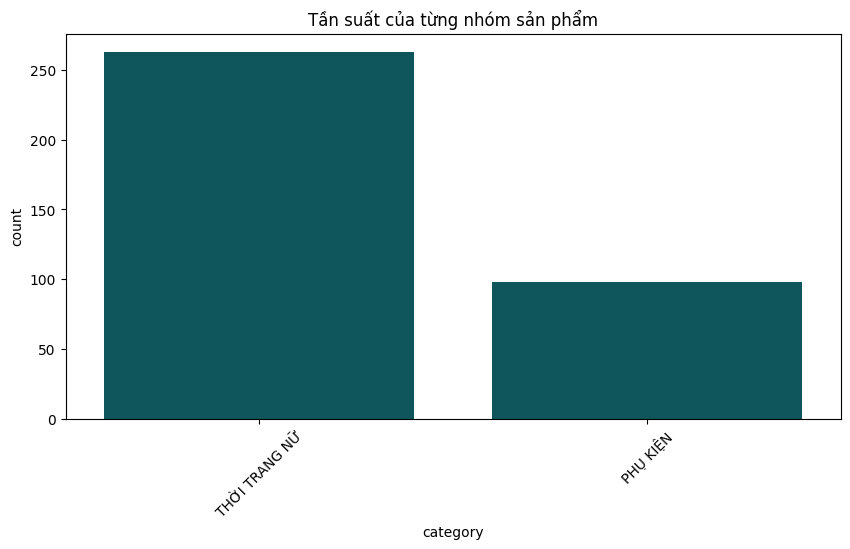

C:\Users\CITEK\AppData\Local\Temp\ipykernel_15848\3609616847.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sub category', order=df['sub category'].value_counts().index, palette=[custom_palette[0]])
C:\Users\CITEK\AppData\Local\Temp\ipykernel_15848\3609616847.py:9: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=df, x='sub category', order=df['sub category'].value_counts().index, palette=[custom_palette[0]])


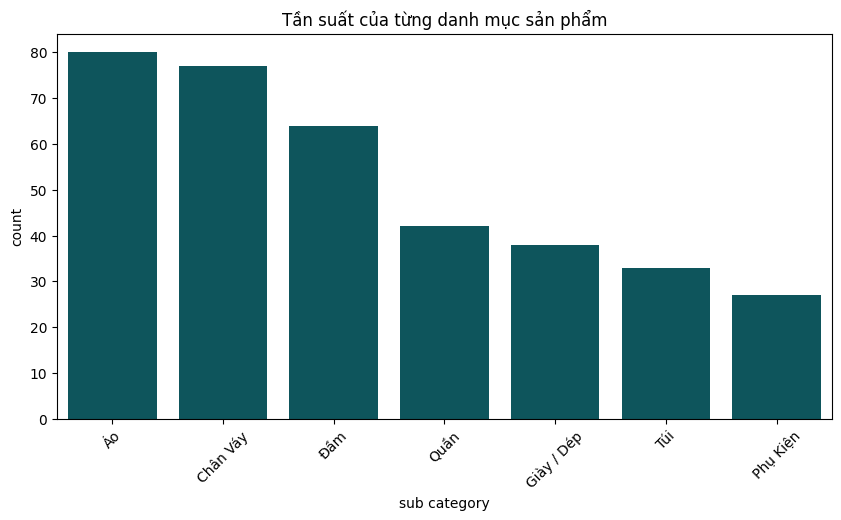

In [16]:
# Tần suất các loại sản phẩm (category và sub category)
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index, palette=[custom_palette[0]])
plt.title("Tần suất của từng nhóm sản phẩm")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='sub category', order=df['sub category'].value_counts().index, palette=[custom_palette[0]])
plt.title("Tần suất của từng danh mục sản phẩm")
plt.xticks(rotation=45)
plt.show()


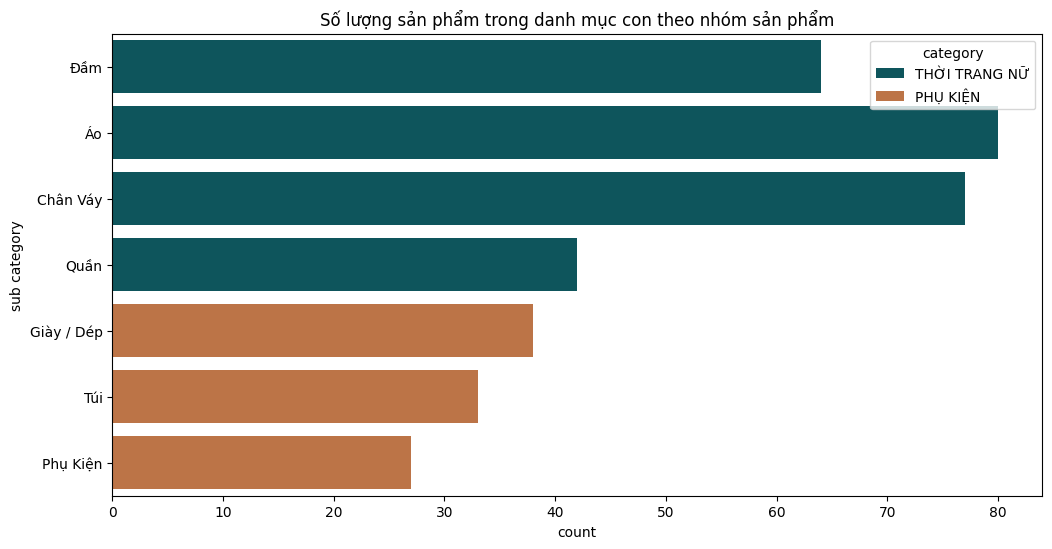

In [18]:
# Sản phẩm theo từng loại (kết hợp category và sub category)
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='sub category', hue='category', palette=custom_palette)
plt.title("Số lượng sản phẩm trong danh mục con theo nhóm sản phẩm")
plt.legend(title="category", loc="upper right")
plt.show()

In [19]:
# Chuyển đổi price string thành số
df['price'] = df['price string'].str.replace("VND", "").str.replace(".", "").astype(float)

In [20]:
# Phân tích giá trung bình và phân phối giá
price_stats = df.groupby(['category', 'sub category'])['price'].agg(['mean', 'min', 'max'])
print("\nThống kê giá trung bình, nhỏ nhất và lớn nhất theo category và sub category:")
print(price_stats)


Thống kê giá trung bình, nhỏ nhất và lớn nhất theo category và sub category:
                                    mean        min        max
category      sub category                                    
PHỤ KIỆN      Giày / Dép    1.414158e+06   599000.0  2198000.0
              Phụ Kiện      9.054074e+05   498000.0  1598000.0
              Túi           2.285879e+06  1698000.0  2498000.0
THỜI TRANG NỮ Chân Váy      1.322675e+06  1098000.0  1798000.0
              Quần          1.286095e+06  1098000.0  2298000.0
              Áo            1.439250e+06   698000.0  2498000.0
              Đầm           2.227688e+06  2098000.0  3998000.0


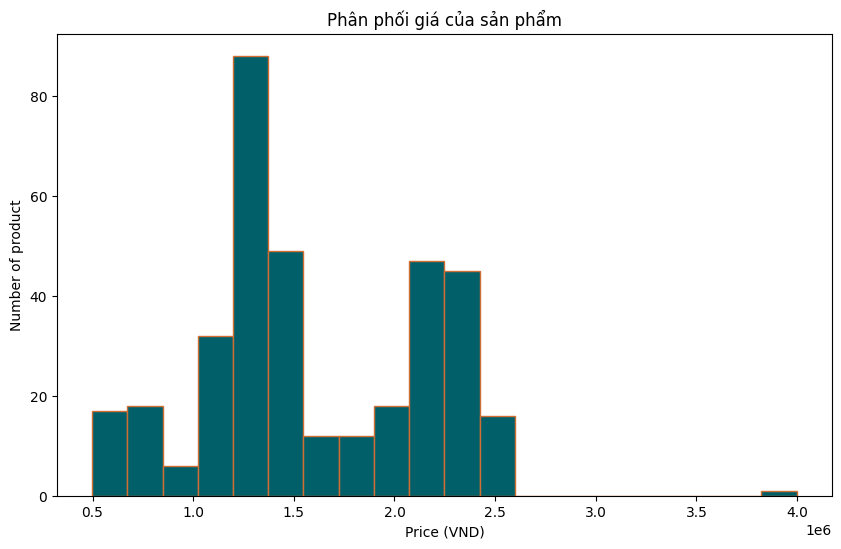

In [21]:
# Histogram phân phối giá của sản phẩm
plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=20, color='#015f69', edgecolor='#d06f33')
plt.title("Phân phối giá của sản phẩm")
plt.xlabel("Price (VND)")
plt.ylabel("Number of product")
plt.show()

C:\Users\CITEK\AppData\Local\Temp\ipykernel_15848\634609168.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y='price', palette=custom_palette)


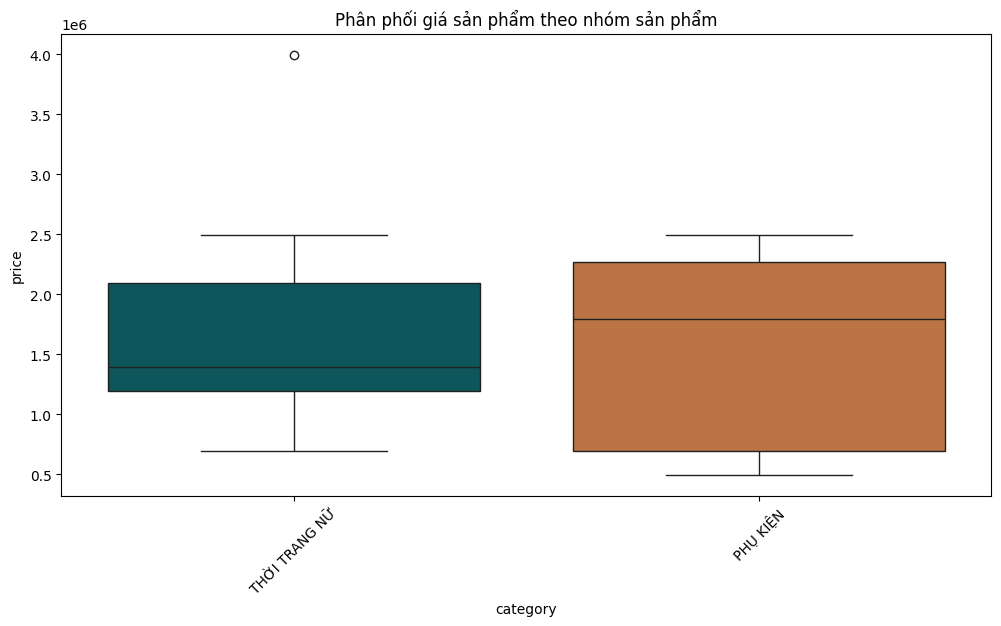

In [22]:
# Trực quan hóa phân phối giá theo category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='category', y='price', palette=custom_palette)
plt.title("Phân phối giá sản phẩm theo nhóm sản phẩm")
plt.xticks(rotation=45)
plt.show()

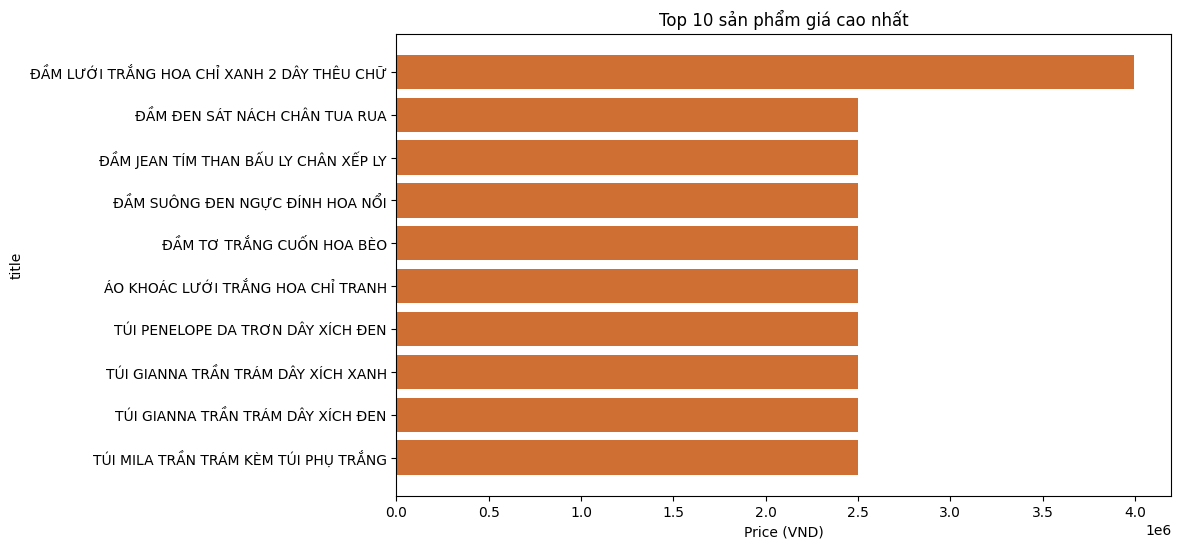

In [26]:
# Top 10 sản phẩm đắt nhất
top_10_expensive_products = df.nlargest(10, 'price')[['title', 'price', 'category']]

plt.figure(figsize=(10, 6))
plt.barh(top_10_expensive_products['title'], top_10_expensive_products['price'], color='#d06f33')
plt.title("Top 10 sản phẩm giá cao nhất")
plt.xlabel("Price (VND)")
plt.ylabel("title")
plt.gca().invert_yaxis()  
plt.show()